In [11]:

import pennylane as qml
from pennylane import numpy as np
import jax

In [15]:
dataset = qml.data.load('qchem', molname="CH4")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  18
The Hamiltonian is    (-23.626576446939104) [I0]
+ (0.07312927482748455) [Z16]
+ (0.07312927482748477) [Z17]
+ (0.10357132197941303) [Z14]
+ (0.10357132197941304) [Z15]
+ (0.10357132197941399) [Z12]
+ (0.10357132197941409) [Z10]
+ (0.1035713219794141) [Z11]
+ (0.10357132197941421) [Z13]
+ (0.45549481664172436) [Z8]
+ (0.4554948166417247) [Z9]
+ (0.45549481664172536) [Z4]
+ (0.4554948166417254) [Z5]
+ (0.4554948166417255) [Z6]
+ (0.45549481664172575) [Z7]
+ (0.6520110321230311) [Z3]
+ (0.6520110321230312) [Z2]
+ (6.263280232304223) [Z0]
+ (6.263280232304225) [Z1]
+ (-0.004828951442895406) [Y4 Y6]
+ (-0.004828951442895406) [X4 X6]
+ (-0.0025724705664083433) [Y12 Y14]
+ (-0.0025724705664083433) [X12 X14]
+ (-0.0018783832268373492) [Y10 Y12]
+ (-0.0018783832268373492) [X10 X12]
+ (-0.0016298322343389136) [Y6 Y8]
+ (-0.0016298322343389136) [X6 X8]
+ (-0.001476320698187286) [Y9 Y11]
+ (-0.001476320698187286) [X9 X11]
+ (0.002303372780026545) [Y1 Y3]
+ (0.00230337278002

In [16]:
dev = qml.device("lightning.qubit", wires=qubits)
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [18]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [19]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [20]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -22.39914322 Ha


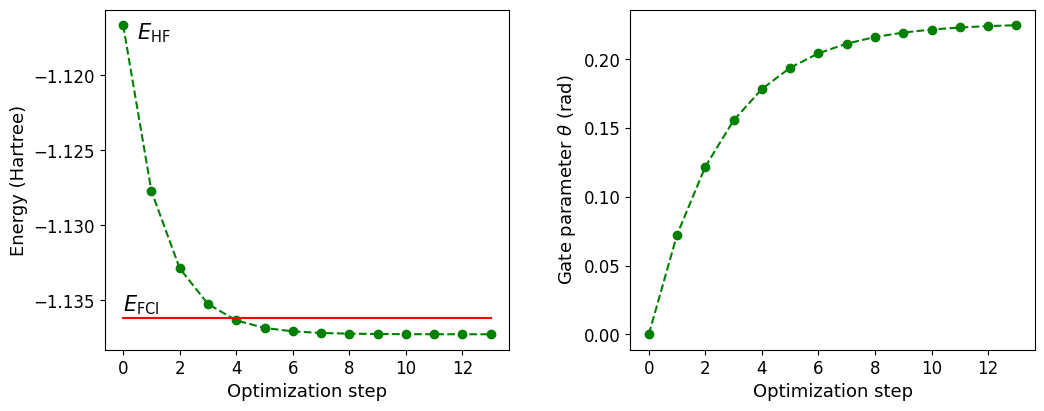

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()